# PROYECTO IMAGEN - PARTE 2 - DENSENET 121

## DENSENET
* DenseNet es una arquitectura de red neuronal convolucional cuya característica es que cada capa está conectada directamente con todas las capas posteriores. 
* Esta arquitectura viene en varias configuraciones, como DenseNet-121, DenseNet-169, DenseNet-201 y DenseNet-264, donde los números indican la cantidad de capas. Estas variantes permiten adaptarse a diferentes necesidades de recursos y situaciones específicas.
* DenseNet se ha utilizado en una variedad de aplicaciones de visión por computadora, como la clasificación de imágenes, detección de objetos y segmentación de imágenes, debido a su alta precisión y eficiencia.

In [1]:
    # Importar librerías necesarias
import numpy as np  # Manipulación de arrays
import pandas as pd  # Manipulación de datos
import matplotlib.pyplot as plt  # Crear gráficos
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import math
import cv2  # Procesamiento de imágenes
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import UpSampling2D, Input
import keras
from tensorflow.keras.applications import VGG19
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D,GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.utils import layer_utils, np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras import losses
from tensorflow.python.keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# https://www.kaggle.com/datasets/deadskull7/fer2013

In [2]:
df=pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# PREPROCESAMIENTO DE LOS DATOS

In [3]:
# Convertir las imágenes de la columna 'pixels' en matrices numpy
def preprocess_pixels(pixels):
    # Convertir la cadena de píxeles en una lista de enteros
    pixels = np.array(pixels.split(), dtype=int)
    # Redimensionar a 48x48 (tamaño de imagen en FER-2013)
    return pixels.reshape(48, 48, 1)

# Aplicar la función de preprocesamiento a todas las imágenes
x = np.array(df['pixels'].apply(preprocess_pixels).tolist())

# Convertir las etiquetas en un array numpy
y = df['emotion'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Replicar el canal para convertir imágenes de 1 canal (grises) a 3 canales (RGB)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# Preprocess input images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Preprocess input images using densenet preprocessing
x_train = tf.keras.applications.densenet.preprocess_input(x_train)
x_test = tf.keras.applications.densenet.preprocess_input(x_test)


x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.1)


y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

print('Train Images Shape:      ', x_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:     ', x_test.shape)
print('Test Labels Shape:       ', y_test.shape)

print("\nData Val Shape")
print("X_val :                   ", x_val.shape)
print("Y_val :                   ", y_val.shape)


Train Images Shape:       (25838, 48, 48, 3)
Train Labels Shape:       (25838, 7)

Test Images Shape:      (7178, 48, 48, 3)
Test Labels Shape:        (7178, 7)

Data Val Shape
X_val :                    (2871, 48, 48, 3)
Y_val :                    (2871, 7)


In [4]:

# Cambiar la forma de entrada a (48, 48, 3) 
inputs = Input(shape=(48, 48, 3))

# Redimensionar las imágenes a 224x224 para DenseNet
resized_inputs = UpSampling2D(size=(224 // 48, 224 // 48))(inputs)


train_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,)

val_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,)

test_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,)

# MODELADO

## Características
* Se utilizó la función preprocess_input de TensorFlow/Keras que aplica una serie de transformaciones específicas a los datos de entrada.
* Uso de data augmentation.
* Uso de earlystop, reduce_lr.
* EPOCHS 15
* BATCHSIZE 32
* LR 0.0001

In [7]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=resized_inputs)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)

# and a logistic layer -- l we have 7 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model0 = Model(inputs=inputs, outputs=predictions, name="densenet")

model0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model0.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 192, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 198, 198, 3)  0           up_sampling2d[0][0]              
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 96, 64)   9408        zero_padding2d_2[0][0]           
___________________________________________________________________________________________

## ENTRENAR MODELO

In [8]:
batch_size=32

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              
                              patience=2,
                              verbose=1,
                              min_lr=0.00001)

callbacks = [earlystop, reduce_lr]

History0 = model0.fit(train_generator.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 15, 
                              callbacks = callbacks,
                              validation_data = (x_val,y_val),
                              verbose = 1)

Epoch 1/15
808/808 [==============================] - 248s 272ms/step - loss: 1.3682 - accuracy: 0.4823 - val_loss: 1.0550 - val_accuracy: 0.5890
Epoch 2/15
808/808 [==============================] - 212s 262ms/step - loss: 1.0675 - accuracy: 0.5986 - val_loss: 0.9992 - val_accuracy: 0.6245
Epoch 3/15
808/808 [==============================] - 212s 262ms/step - loss: 0.9687 - accuracy: 0.6387 - val_loss: 0.9188 - val_accuracy: 0.6545
Epoch 4/15
808/808 [==============================] - 212s 262ms/step - loss: 0.9097 - accuracy: 0.6622 - val_loss: 0.9007 - val_accuracy: 0.6562
Epoch 5/15
808/808 [==============================] - 212s 263ms/step - loss: 0.8527 - accuracy: 0.6819 - val_loss: 0.9212 - val_accuracy: 0.6517
Epoch 6/15
808/808 [==============================] - 453s 561ms/step - loss: 0.8052 - accuracy: 0.7006 - val_loss: 0.8934 - val_accuracy: 0.6681
Epoch 7/15
808/808 [==============================] - 1603s 2s/step - loss: 0.7649 - accuracy: 0.7180 - val_loss: 0.8643 - v

## EVALUAR MODELO

In [10]:
# Evaluate the model
test_loss, test_accuracy = model0.evaluate(test_generator.flow(x_test,y_test,batch_size=batch_size))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
accuracy_densenet=test_accuracy

225/225 [==============================] - 19s 77ms/step - loss: 0.8609 - accuracy: 0.6950
Test Loss: 0.8608655333518982
Test Accuracy: 0.6950404047966003


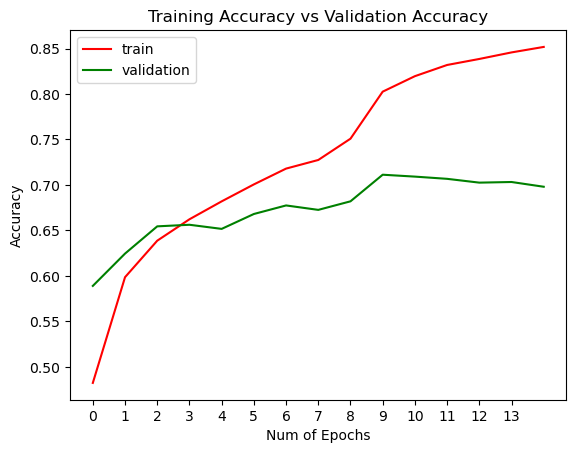

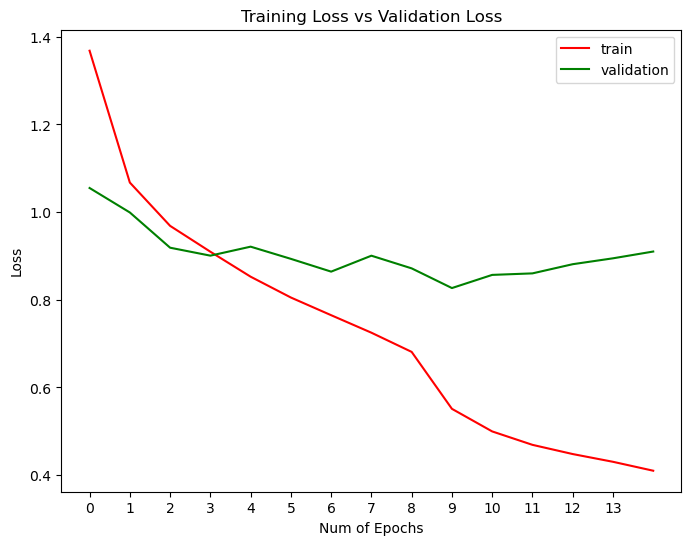

In [11]:
plt.figure(0)
plt.plot(History0.history['accuracy'],'r')
plt.plot(History0.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 14, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(History0.history['loss'],'r')
plt.plot(History0.history['val_loss'],'g')
plt.xticks(np.arange(0, 14, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

# COMPARACIÓN MODELOS HASTA EL 4

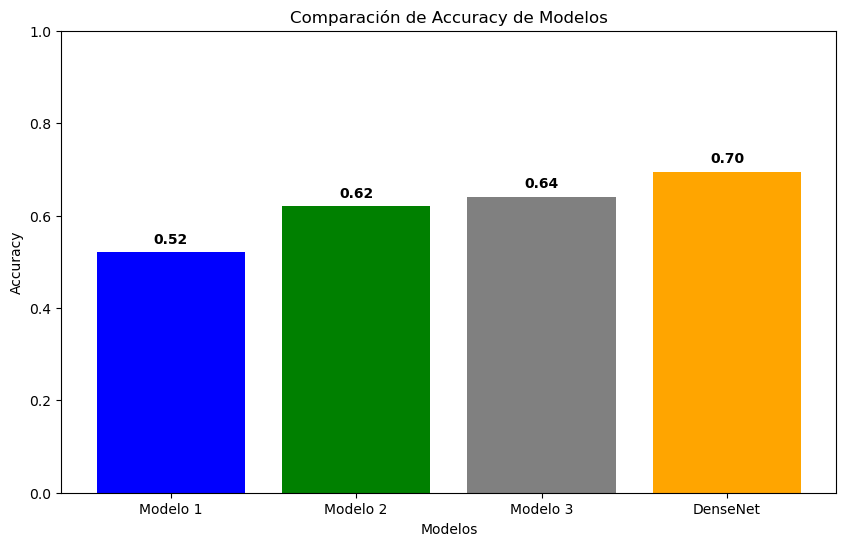

In [12]:
accuracy_modelo1 = 0.52
accuracy_modelo2 = 0.62
accuracy_modelo3 = 0.64
accuracy_densenet = accuracy_densenet  # Añadir el valor de accuracy para DenseNet

# Nombres de los modelos
model_names = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'DenseNet']
accuracies = [accuracy_modelo1, accuracy_modelo2, accuracy_modelo3, accuracy_densenet]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'grey', 'orange'])

# Añadir títulos y etiquetas
plt.title('Comparación de Accuracy de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Asegura que el eje y va de 0 a 1

# Añadir valores de accuracy encima de las barras
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Mostrar el gráfico
plt.show()